In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Eksploracja

In [4]:
penguins = pd.read_csv('penguins.csv')
penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


In [6]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


Wartości Na występują jedynie w dwóch wierszach dlatego postanowiłem te wiersze usunąć i analizować pozostałe.

In [10]:
penguins.dropna(inplace=True)
features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
target = 'Species'
X, y = penguins[features], penguins[target]
print('X:')
display(X)
print('y:')
display(y)

X:


,CulmenLength,CulmenDepth,FlipperLength,BodyMass
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
339,55.8,19.8,207.0,4000.0
340,43.5,18.1,202.0,3400.0
341,49.6,18.2,193.0,3775.0
342,50.8,19.0,210.0,4100.0


y:


0      0
1      0
2      0
4      0
5      0
      ..
339    2
340    2
341    2
342    2
343    2
Name: Species, Length: 342, dtype: int64

In [12]:
pd.Series(y).value_counts(normalize=True)

0    0.441520
1    0.359649
2    0.198830
Name: Species, dtype: float64

Unique values: 164


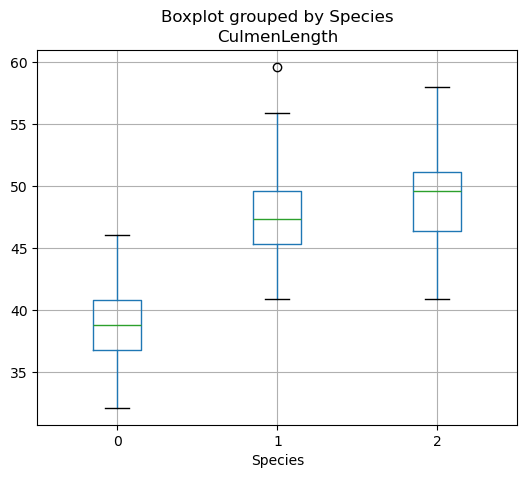

Unique values: 80


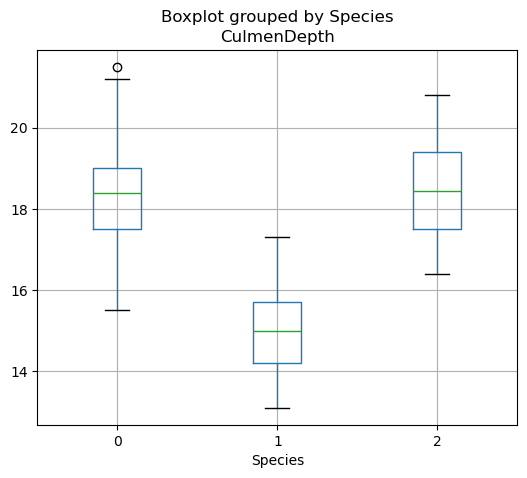

Unique values: 55


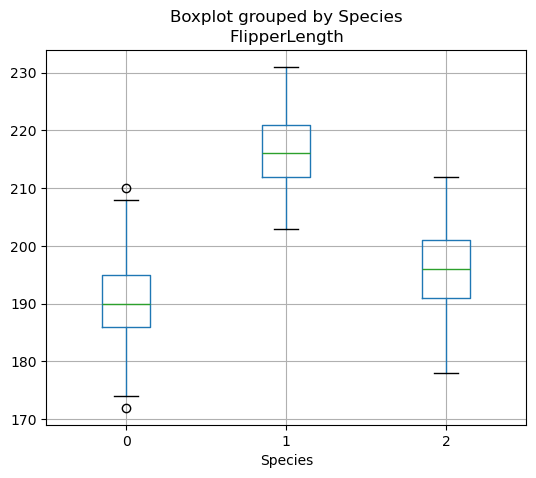

Unique values: 94


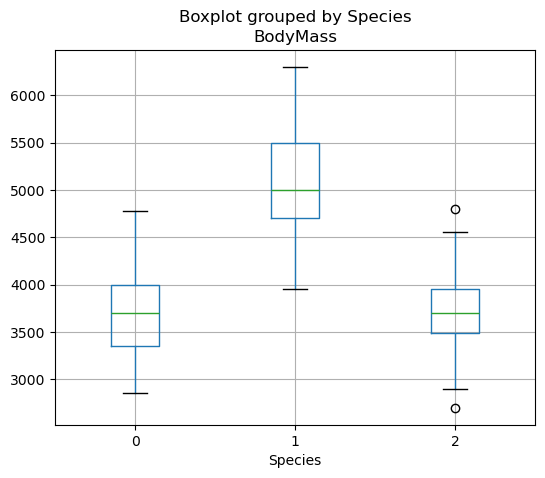

In [14]:
for col in features:
    print(f'Unique values: {len(penguins[col].unique())}')
    penguins.boxplot(column=col, by='Species', figsize=(6, 5))
    plt.title(col)
    plt.show()

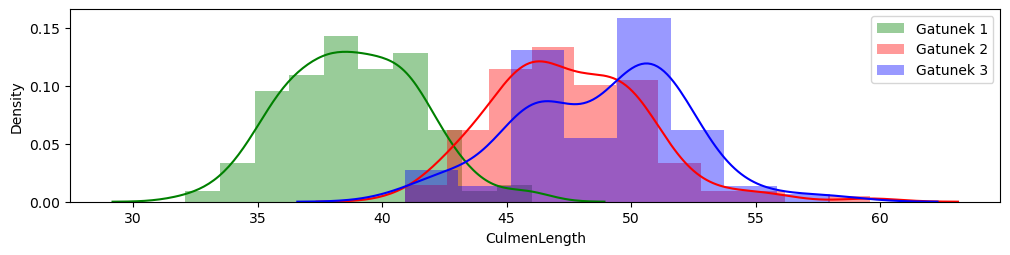

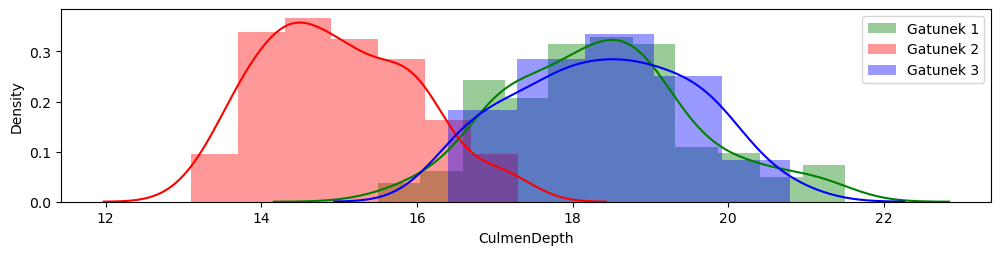

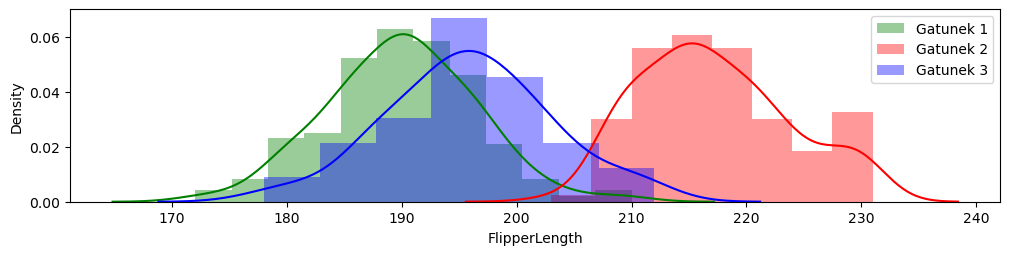

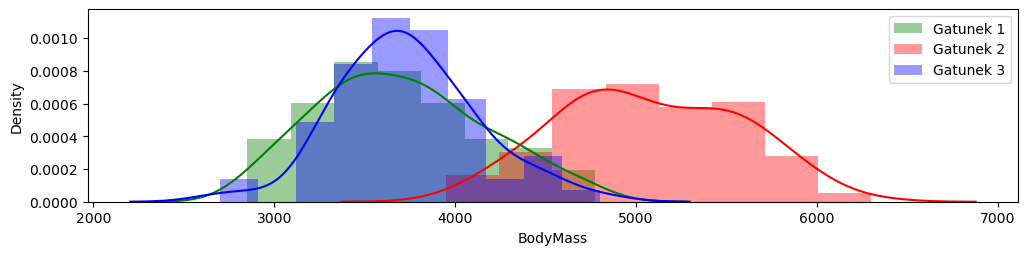

In [16]:
import warnings
warnings.filterwarnings('ignore')

for col in features:
    plt.figure(figsize=(12, 2.5))
    sns.distplot(penguins.loc[penguins['Species']==0, col], kde=True, color='green', label='Gatunek 1')
    sns.distplot(penguins.loc[penguins['Species']==1, col], kde=True, color='red', label='Gatunek 2')
    sns.distplot(penguins.loc[penguins['Species']==2, col], kde=True, color='blue', label='Gatunek 3')
    plt.legend(loc='upper right')
    plt.show()

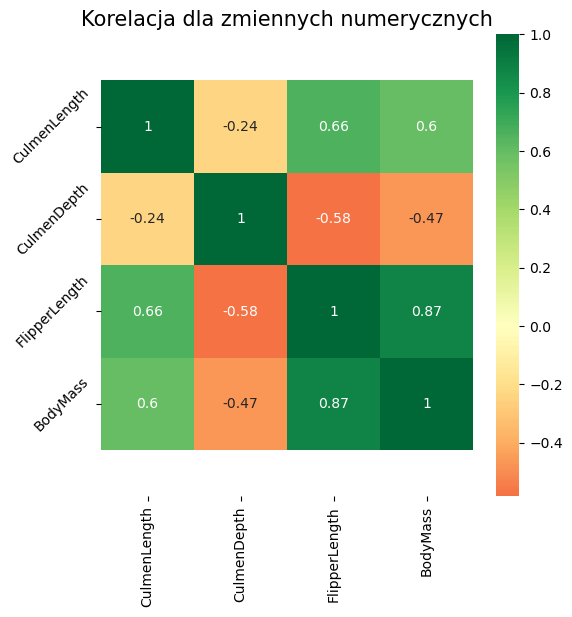

In [18]:
plt.figure(figsize=(6, 6))
ax = sns.heatmap(X.corr(),
                 xticklabels=X.corr().columns,
                 yticklabels=X.corr().columns,
                 cmap='RdYlGn',
                 center=0,
                 annot=True)

plt.title('Korelacja dla zmiennych numerycznych', fontsize=15)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=45)
plt.show()

In [20]:
corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

CulmenLength     0.779857
FlipperLength    0.357472
BodyMass         0.209717
CulmenDepth     -0.183090
dtype: float64

## Wybór zmiennych
    Wszystkie zmienne są ze sobą w pewnym stopniu skorelowane. Na podstawie współczynnika korelacji punktowo-dwuseryjnej oraz histogramów wybrałem zmienne CulmenLength oraz FlipperLength. Na histogramach widać, że na podstawie tych zmiennych można łatwo odseparować pierwszy 
    i drugi gatunek. Są to też zmienne najmniej ze sobą skorelowane. 

## Podział i skalowanie zmiennych

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[['CulmenLength', 'FlipperLength']], y, test_size=0.30, random_state=0, stratify=y)
print (f'Treningowe obserwacje: {X_train.shape[0]}\nTestowe obserwacje: {X_test.shape[0]}')

Treningowe obserwacje: 239
Testowe obserwacje: 103


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

## Funkcje służące do oceny modelu

In [101]:
def plot_classification_surface(X_plot, y_plot, trained_model):
    plt.figure(figsize=(12, 7))

    # określenie granic zbioru
    min1, max1 = X_plot[:, 0].min()-1, X_plot[:, 0].max()+1
    min2, max2 = X_plot[:, 1].min()-1, X_plot[:, 1].max()+1

    # skalowanie dla obu osi
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    # utworzenie siatki
    xx, yy = np.meshgrid(x1grid, x2grid)

    # przetworzenie siatki w wektor
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # stworzenie zmiennych objaśniających dla modelu
    grid = np.hstack((r1,r2))

    # predykcja modelu zbioru
    yhat = trained_model.predict(grid)

    # przetworzenie predykcji na decyzji dla konkretnego punktu wykresu
    zz = yhat.reshape(xx.shape)

    # wizualizacja siatki z przyporządkowaną klasą
    plt.contourf(xx, yy, zz, cmap='Paired')

    # tworzenie wykresu punktowego dla klas ze zbioru X
    for class_value in range(3):

        # przyporządkowanie klasy (y) do obsewacji (X)
        row_ix = np.where(y_plot == class_value)

        # stworzenie wykresu punktowego
        plt.scatter(X_plot[row_ix, 0], X_plot[row_ix, 1], cmap='Paired', alpha=0.3, label=class_value)

    # wizualizacja wykresu
    plt.legend(loc='upper right')
    plt.show()

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    f1_metric = f1_score(y_checked, predictions, average='macro')
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric},
                                                 ignore_index=True)
    return metrics_dataframe

## Logistic Regression

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model_lr = LogisticRegression(n_jobs=-1)
params_lr = {'penalty':['l1', 'l2', 'elasticnet', 'none'],
            'C':np.arange(0, 1.01, 0.01).tolist()}

model_lr_GS = GridSearchCV(model_lr, params_lr, scoring='f1_macro', verbose=1, n_jobs=-1)
model_lr_GS.fit(X_train_standardized, y_train)
print('\nBest hyperparameters:', model_lr_GS.best_params_)
model_lr_v2 = model_lr_GS.best_estimator_

Fitting 5 folds for each of 404 candidates, totalling 2020 fits

Best hyperparameters: {'C': 0.0, 'penalty': 'none'}


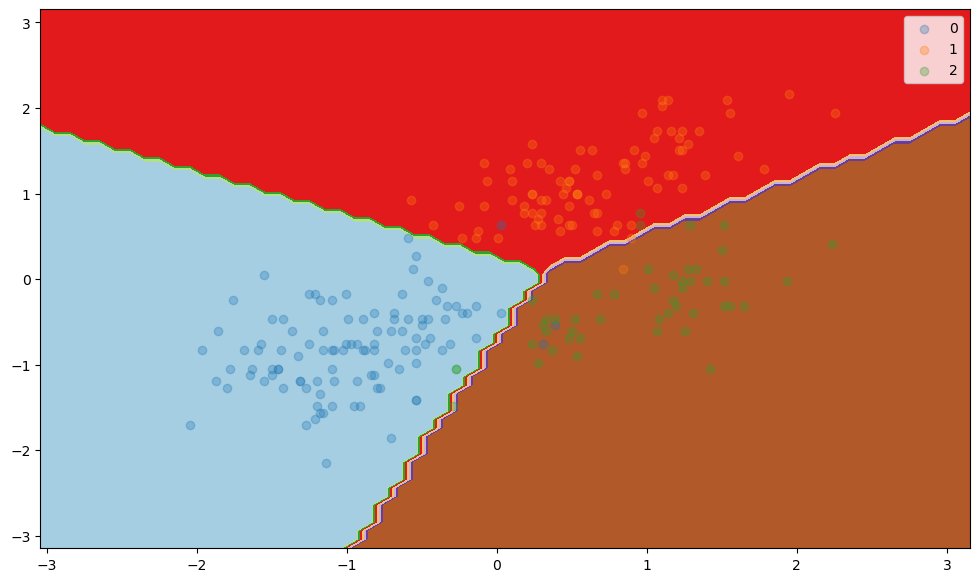

In [108]:
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_lr_v2)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        45
           1       1.00      1.00      1.00        37
           2       0.90      0.86      0.88        21

    accuracy                           0.95       103
   macro avg       0.94      0.94      0.94       103
weighted avg       0.95      0.95      0.95       103



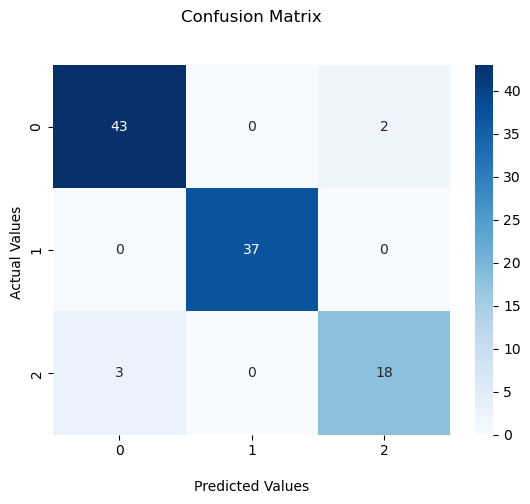

,Model,F1_score
0,Logistic Regression,0.941035


In [110]:
calculate_metrics(model_lr_v2, 'Logistic Regression', X_test_standardized, y_test)

## KNN (K Nearest Neighbours)

In [113]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_jobs=-1)
params_knn = {'n_neighbors':np.arange(0, X_train.shape[0], 1).tolist()}

model_knn_GS = GridSearchCV(model_knn, params_knn, scoring='f1_macro', verbose=1, n_jobs=-1)
model_knn_GS.fit(X_train_standardized, y_train)
print('\nBest hyperparameters:', model_knn_GS.best_params_)
model_knn_v2 = model_knn_GS.best_estimator_

Fitting 5 folds for each of 239 candidates, totalling 1195 fits

Best hyperparameters: {'n_neighbors': 12}


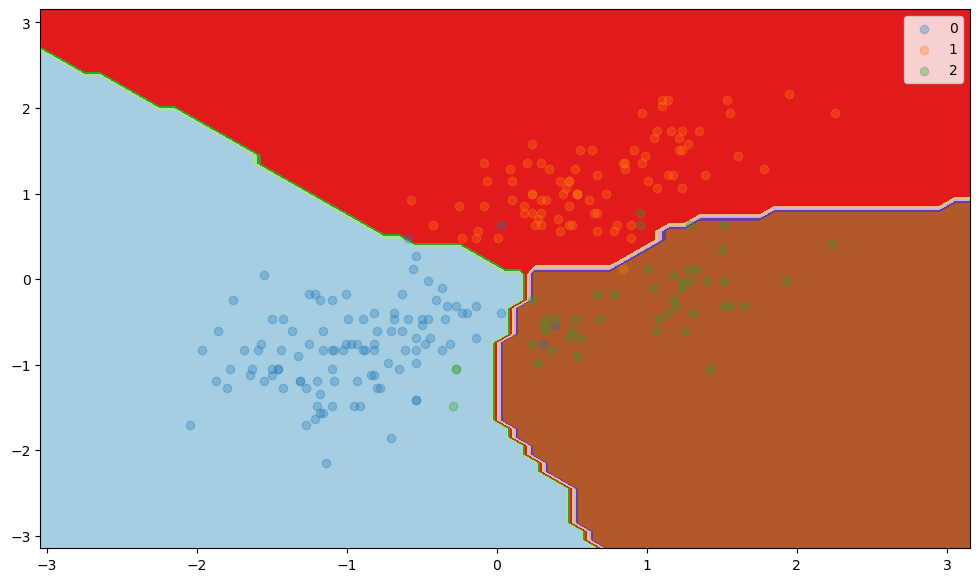

In [115]:
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_knn_v2)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



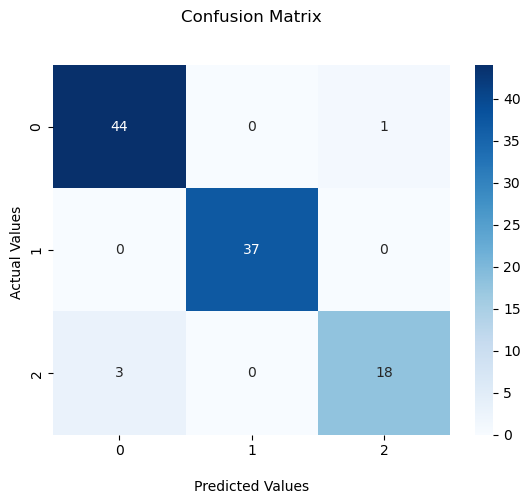

,Model,F1_score
0,Logistic Regression,0.941035
1,KNN,0.952174


In [117]:
calculate_metrics(model_knn_v2, 'KNN', X_test_standardized, y_test)

## Decision Tree

In [120]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()
params_tree = {'max_depth':np.arange(0, int(X_test.shape[0]*0.2), 1).tolist(),
              'min_samples_leaf':np.arange(0, X_test.shape[0], 1).tolist()}

model_tree_GS = GridSearchCV(model_tree, params_tree, scoring='f1_macro', verbose=1, n_jobs=-1)
model_tree_GS.fit(X_train, y_train)
print('\nBest hyperparameters:', model_tree_GS.best_params_)
model_tree_v2 = model_tree_GS.best_estimator_

Fitting 5 folds for each of 2060 candidates, totalling 10300 fits

Best hyperparameters: {'max_depth': 11, 'min_samples_leaf': 3}


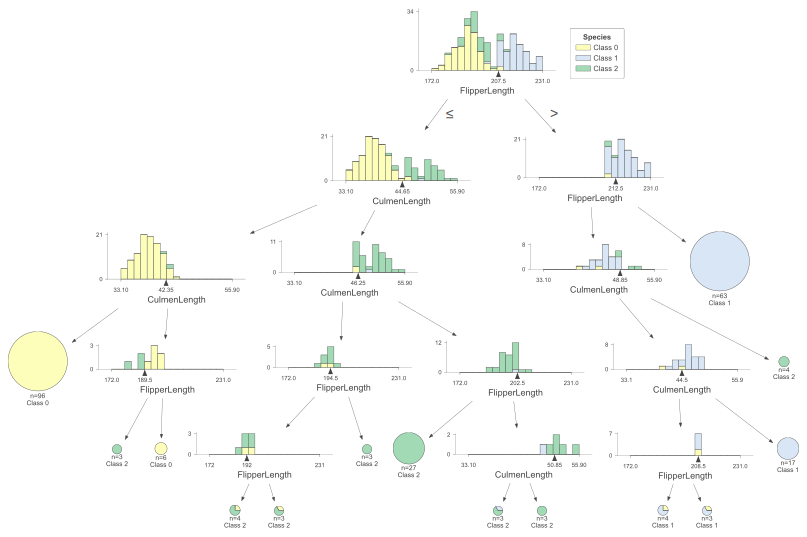

In [122]:
import dtreeviz

viz = dtreeviz.model(model_tree_v2, X_train=X_train, y_train=y_train,
                     target_name='Species', feature_names = X_train.columns)
viz.view()

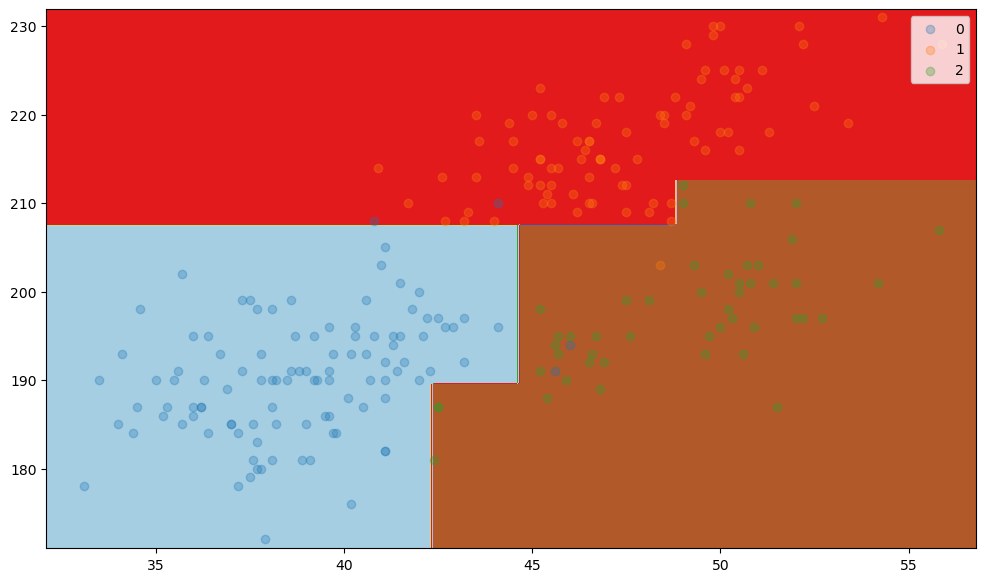

In [124]:
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_tree_v2)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      0.95      0.97        37
           2       0.86      0.90      0.88        21

    accuracy                           0.95       103
   macro avg       0.94      0.94      0.94       103
weighted avg       0.95      0.95      0.95       103



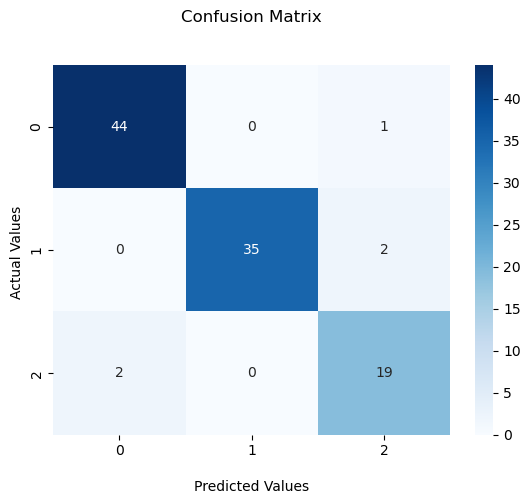

,Model,F1_score
0,Logistic Regression,0.941035
1,KNN,0.952174
2,Tree,0.940992


In [126]:
calculate_metrics(model_tree_v2, 'Tree', X_test, y_test)

## SVM (Support Vector Machines)

In [129]:
from sklearn.svm import SVC

model_svm = SVC(probability=True)
params_svm = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'C':np.arange(0, 1.01, 0.01).tolist()}

model_svm_GS = GridSearchCV(model_svm, params_svm, scoring='f1_macro', verbose=1, n_jobs=-1)
model_svm_GS.fit(X_train_standardized, y_train)
print('\nBest hyperparameters:', model_svm_GS.best_params_)
model_svm_v2 = model_svm_GS.best_estimator_

Fitting 5 folds for each of 404 candidates, totalling 2020 fits

Best hyperparameters: {'C': 0.45, 'kernel': 'linear'}


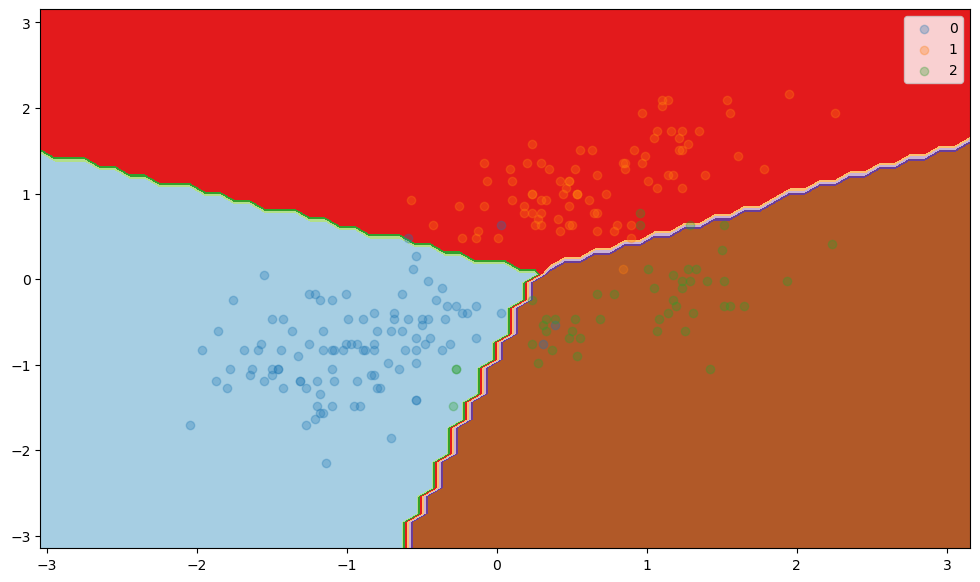

In [131]:
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_svm_v2)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



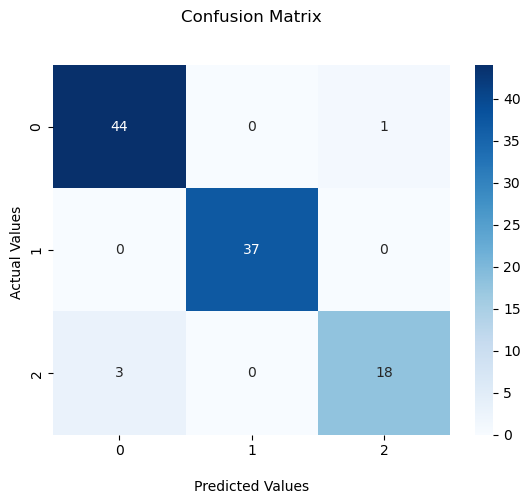

,Model,F1_score
0,Logistic Regression,0.941035
1,KNN,0.952174
2,Tree,0.940992
3,SVM,0.952174


In [133]:
calculate_metrics(model_svm_v2, 'SVM', X_test_standardized, y_test)

## Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_jobs=-1) # najlepsze hiperparametry dla pojedynczego drzewa
params_rf = {'n_estimators':np.arange(0, 100, 1).tolist()}

model_rf_GS = GridSearchCV(model_rf, params_rf, scoring='f1_macro', verbose=1, n_jobs=-1)
model_rf_GS.fit(X_train, y_train)
print('\nBest hyperparameters:', model_rf_GS.best_params_)
model_rf_v2 = model_rf_GS.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best hyperparameters: {'n_estimators': 36}


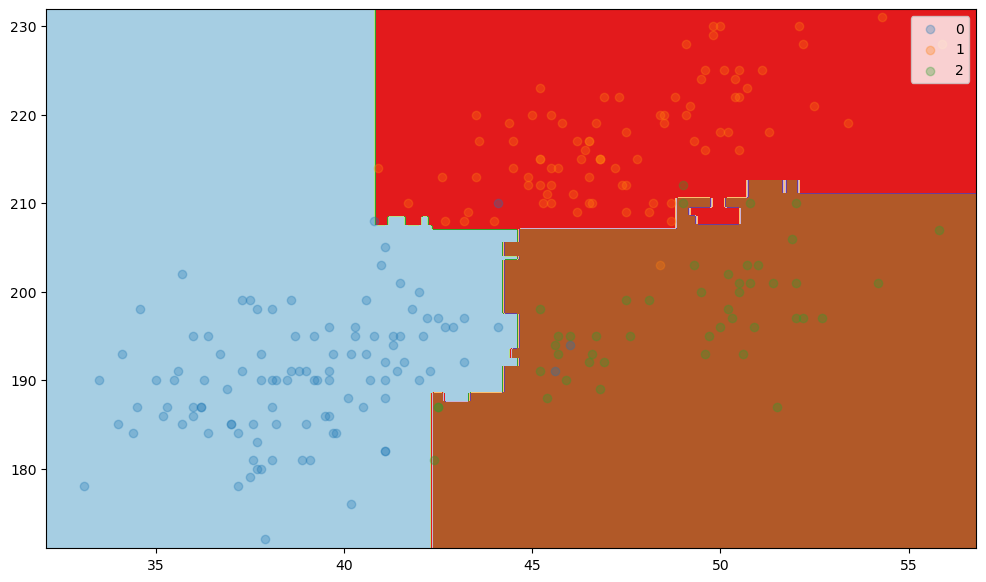

In [138]:
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_rf_v2)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      0.97      0.99        37
           2       0.90      0.90      0.90        21

    accuracy                           0.96       103
   macro avg       0.95      0.95      0.95       103
weighted avg       0.96      0.96      0.96       103



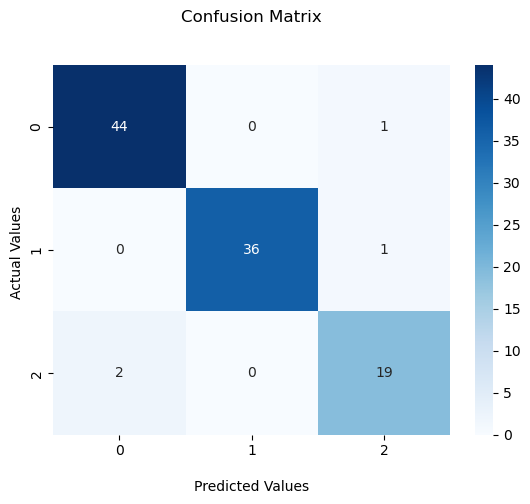

,Model,F1_score
0,Logistic Regression,0.941035
1,KNN,0.952174
2,Tree,0.940992
3,SVM,0.952174
4,Random Forest,0.952699


In [140]:
calculate_metrics(model_rf_v2, 'Random Forest', X_test, y_test)

## AdaBoost

In [143]:
from sklearn.ensemble import AdaBoostClassifier

model_ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, min_samples_leaf=3)) 
params_ab = {'n_estimators':np.arange(0, 100, 1).tolist()}

model_ab_GS = GridSearchCV(model_ab, params_ab, scoring='f1_macro', verbose=1, n_jobs=-1)
model_ab_GS.fit(X_train, y_train)
print('\nBest hyperparameters:', model_ab_GS.best_params_)
model_ab_v2 = model_ab_GS.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best hyperparameters: {'n_estimators': 27}


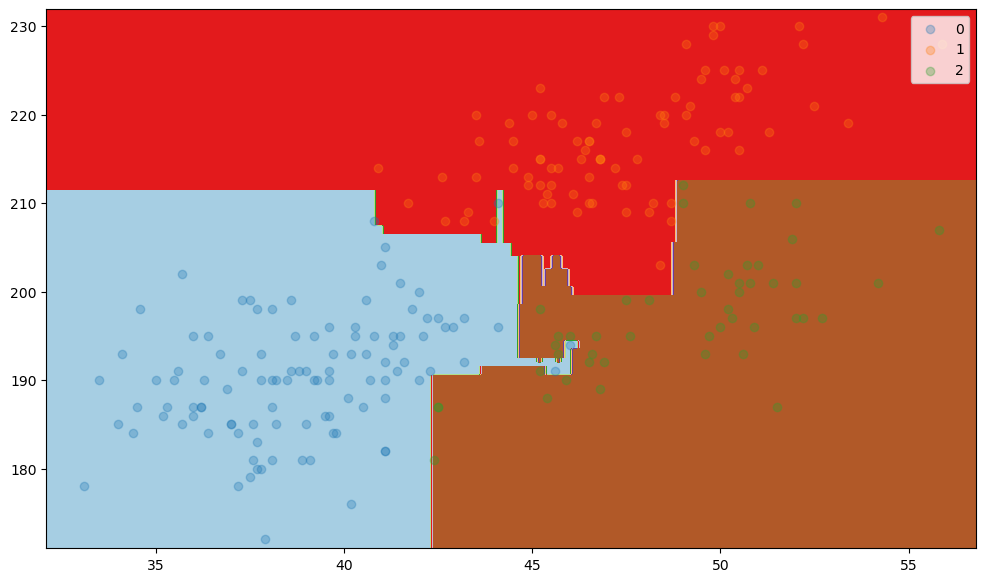

In [145]:
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_ab_v2)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      0.97      0.99        37
           2       0.90      0.90      0.90        21

    accuracy                           0.96       103
   macro avg       0.95      0.95      0.95       103
weighted avg       0.96      0.96      0.96       103



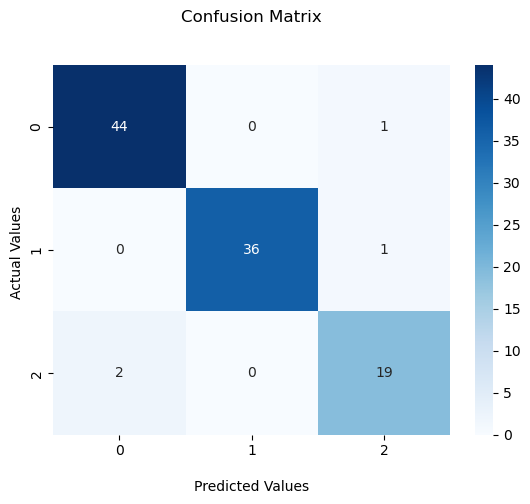

,Model,F1_score
0,Logistic Regression,0.941035
1,KNN,0.952174
2,Tree,0.940992
3,SVM,0.952174
4,Random Forest,0.952699
5,AdaBoost,0.952699


In [147]:
calculate_metrics(model_ab_v2, 'AdaBoost', X_test, y_test)

## Ensembling

In [150]:
from sklearn.ensemble import VotingClassifier

model_voting = VotingClassifier(estimators=[('Tree', model_tree_v2),
                                            ('Random Forest', model_rf_v2),
                                            ('AdaBoost', model_ab_v2)],
                                voting='soft')

model_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('Tree',
                              DecisionTreeClassifier(max_depth=11,
                                                     min_samples_leaf=3)),
                             ('Random Forest',
                              RandomForestClassifier(max_depth=5,
                                                     min_samples_leaf=3,
                                                     n_estimators=36,
                                                     n_jobs=-1)),
                             ('AdaBoost',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                       min_samples_leaf=3),
                                                 n_estimators=27))],
                 voting='soft')

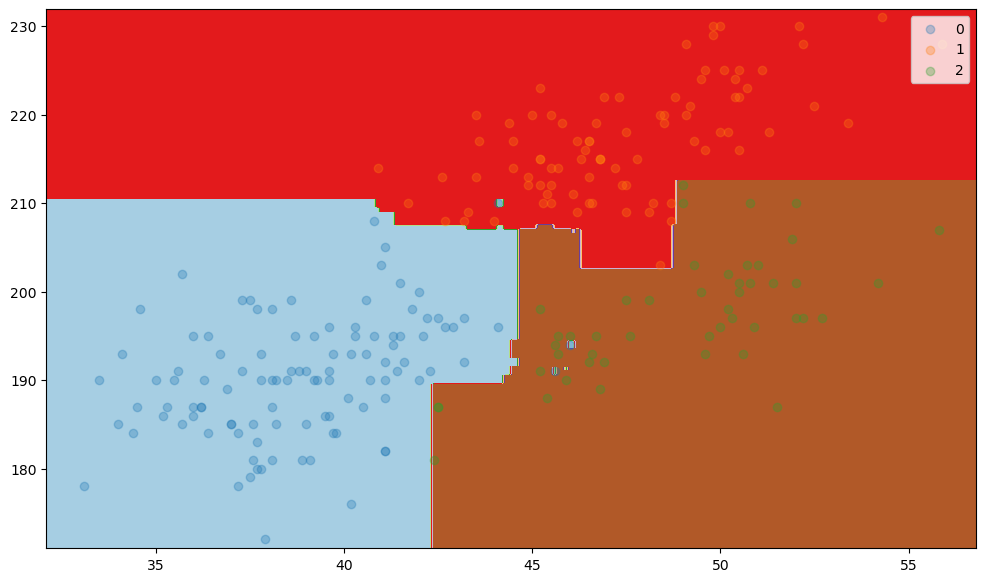

In [152]:
plot_classification_surface(X_plot=np.array(X_train), y_plot=y_train, trained_model=model_voting)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      0.95      0.97        37
           2       0.86      0.90      0.88        21

    accuracy                           0.95       103
   macro avg       0.94      0.94      0.94       103
weighted avg       0.95      0.95      0.95       103



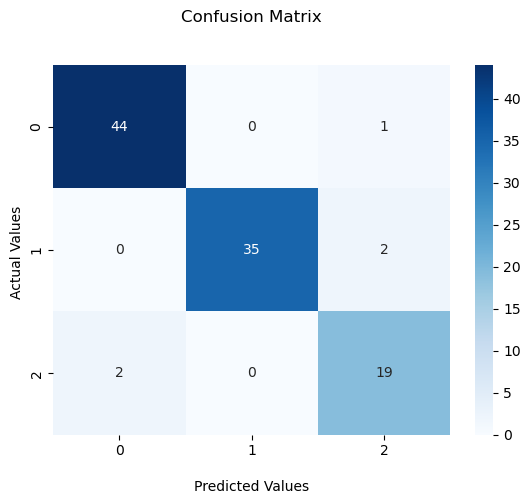

,Model,F1_score
0,Logistic Regression,0.941035
1,KNN,0.952174
2,Tree,0.940992
3,SVM,0.952174
4,Random Forest,0.952699
5,AdaBoost,0.952699
6,VotingClassifier,0.940992


In [154]:
calculate_metrics(model_voting, 'VotingClassifier', X_test, y_test)

In [156]:
model_voting_par = VotingClassifier(estimators=[('Logistic Regression', model_lr_v2),
                                            ('KNN', model_knn_v2),
                                            ('SVM', model_svm_v2)],
                                voting='soft')

model_voting_par.fit(X_train_standardized, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=0.0, n_jobs=-1,
                                                 penalty='none')),
                             ('KNN',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=12)),
                             ('SVM',
                              SVC(C=0.45, kernel='linear', probability=True))],
                 voting='soft')

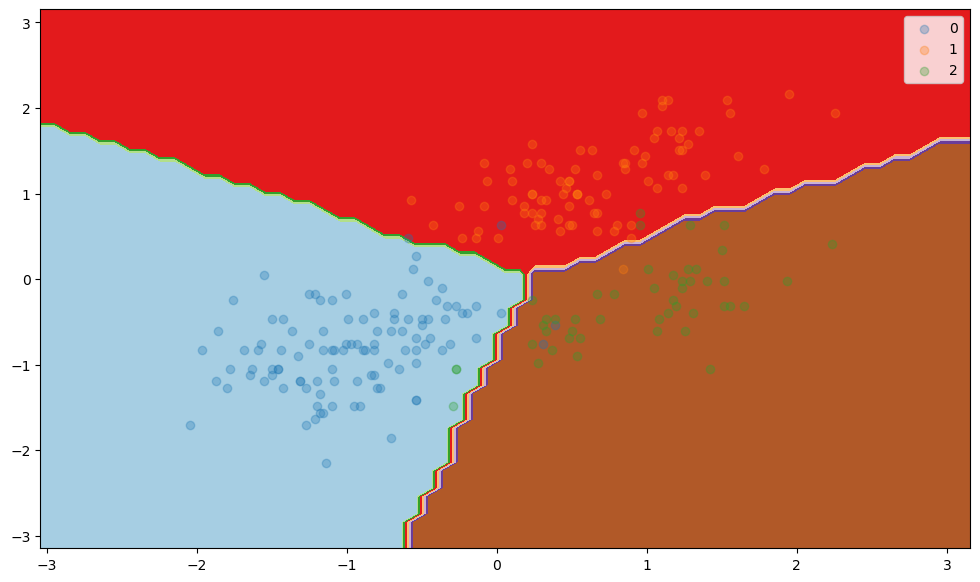

In [158]:
plot_classification_surface(X_plot=X_train_standardized, y_plot=y_train, trained_model=model_voting_par)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



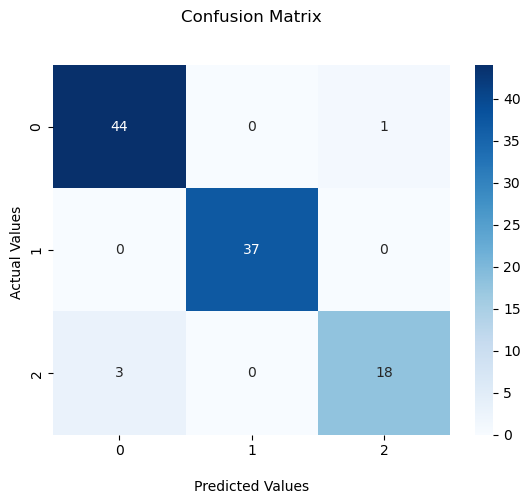

,Model,F1_score
0,Logistic Regression,0.941035
1,KNN,0.952174
2,Tree,0.940992
3,SVM,0.952174
4,Random Forest,0.952699
5,AdaBoost,0.952699
6,VotingClassifier,0.940992
7,VotingClassifier par.,0.952174


In [160]:
calculate_metrics(model_voting_par, 'VotingClassifier par.', X_test_standardized, y_test)